In [55]:
#1. Combine Datasets
#Merge the identity and transaction datasets using TransactionID:

import pandas as pd

# Load datasets
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# Merge datasets
train_data = train_transaction.merge(train_identity, on='TransactionID', how='left')


In [3]:
train_data.TransactionDT.min()

86400

In [57]:
#The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).
#“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) 
#so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, 
#which would correspond to day 183.”
# If TransactionDT is sequential, we can treat it as a proxy for time
train_data['time_index'] = train_data['TransactionDT'] - train_data['TransactionDT'].min()

# Convert 'time_index' into a datetime-like feature (optional if no actual timestamp exists)
train_data['time'] = pd.to_datetime(train_data['time_index'], unit='s')

In [69]:
#2. Datetime Conversion
#Convert TransactionDT into a meaningful datetime format:
# Convert TransactionDT to datetime
start_date = pd.to_datetime('2023-12-30')  # Arbitrary start date
train_data['TransactionDate'] = train_data['TransactionDT'].apply(lambda x: start_date + pd.to_timedelta(x, unit='s'))
train_data['DayOfWeek'] = train_data['TransactionDate'].dt.dayofweek
train_data['Hour'] = train_data['TransactionDate'].dt.hour
train_data['Date'] = train_data['TransactionDate'].dt.date



In [63]:
train_data['time'].min()

Timestamp('1970-01-01 00:00:00')

In [9]:
train_data.Hour.max()

23

In [71]:
#3. Filter Fraudulent Transactions
fraud_data = train_data[train_data['isFraud'] == 1]

<Axes: title={'center': 'Daily Fraudulent Transactions'}, xlabel='Date'>

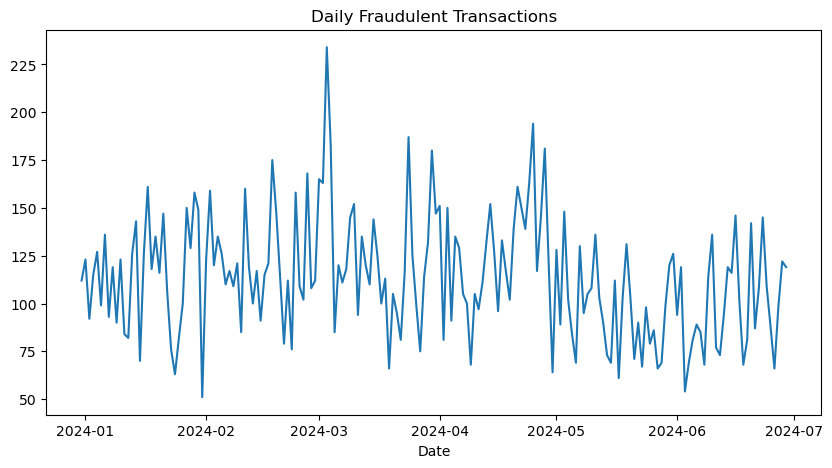

In [73]:
#Step 2: Temporal Aggregations
#1. Daily Fraud Counts
#Aggregate by day to examine daily fraud patterns:
daily_fraud = fraud_data.groupby('Date').size()

daily_fraud.plot(title="Daily Fraudulent Transactions", figsize=(10, 5))


In [75]:
df_daily_fraud = pd.DataFrame(daily_fraud)
df_daily_fraud.rename(columns={0: "count"}, inplace=True)

In [77]:
df_daily_fraud.head()

,count
Date,
2023-12-31,112
2024-01-01,123
2024-01-02,92
2024-01-03,115
2024-01-04,127


In [35]:
print(df_daily_fraud.columns.tolist())

['count']


<Axes: title={'center': 'Hourly Fraudulent Transactions'}, xlabel='Hour'>

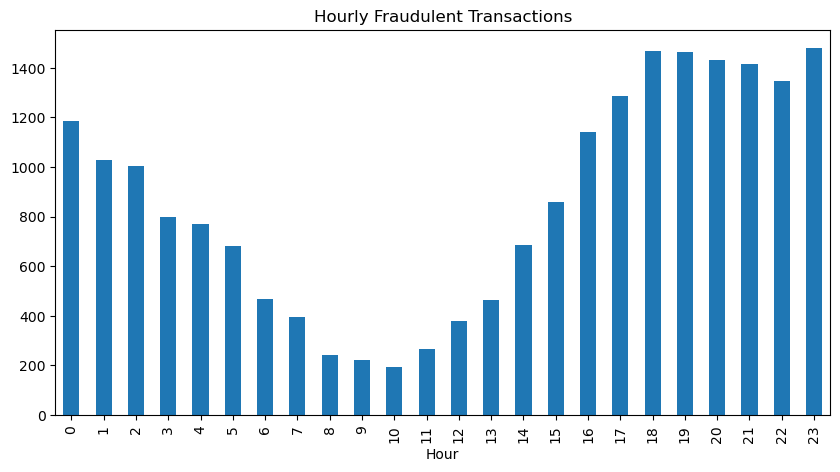

In [79]:
# aggregating by hour, indicating which hour of the day there are most fraudulent transactions
hourly_fraud = fraud_data.groupby('Hour').size()
hourly_fraud.plot(kind='bar', title="Hourly Fraudulent Transactions", figsize=(10, 5))

<Axes: title={'center': 'Weekly Fraudulent Transactions'}, xlabel='DayOfWeek'>

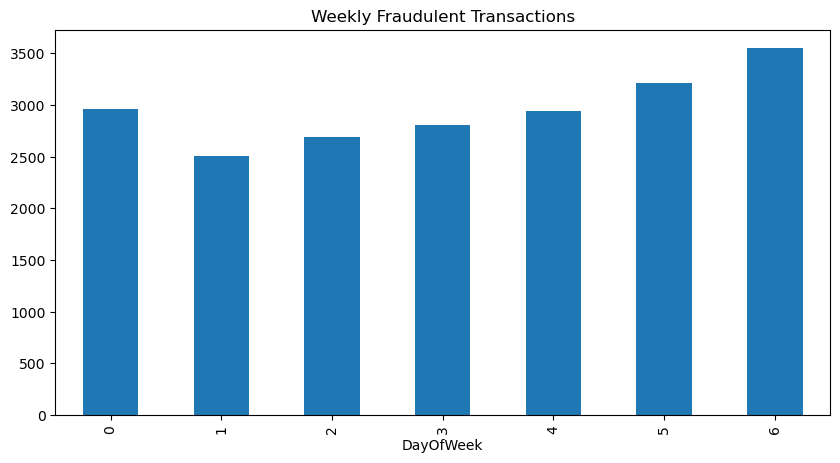

In [81]:
# aggregating by day of week, indicating which day of the week there are most fraudulent transactions
weekly_fraud = fraud_data.groupby('DayOfWeek').size()
weekly_fraud.plot(kind='bar', title="Weekly Fraudulent Transactions", figsize=(10, 5))


<Axes: title={'center': '7 and 30-Day Moving Average of Fraudulent Transactions'}, xlabel='Date'>

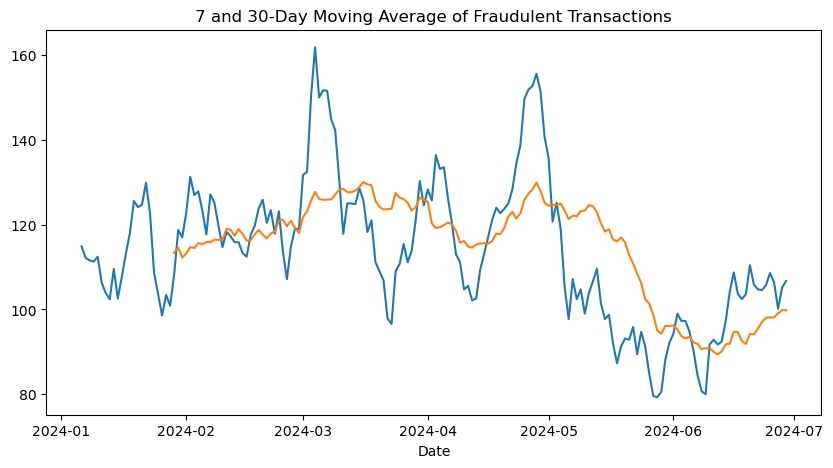

In [87]:
#Step 3: Moving Average
#Create Moving Averages to Smooth Trend
daily_fraud_ma = daily_fraud.rolling(window=7).mean()
daily_fraud_ma2 = daily_fraud.rolling(window=30).mean()
daily_fraud_ma.plot(title="7-Day Moving Average of Fraudulent Transactions", figsize=(10, 5))
daily_fraud_ma2.plot(title="7 and 30-Day Moving Average of Fraudulent Transactions", figsize=(10, 5))


In [ ]:
#moving average removed some noises, noticeable peaks of fraud on second and 5th month of observation. 
#Cannot really name a month as this date estimates are derivated from a time delta starting at an arbtrary date I set.
#30 day moving average not a good choice given how much granularity we lose

In [105]:
daily_fraud.head()

Date
2023-12-31    112
2024-01-01    123
2024-01-02     92
2024-01-03    115
2024-01-04    127
dtype: object

In [89]:
daily_fraud = daily_fraud.dropna()
# Handle missing values (if any)
daily_fraud_cleaned = daily_fraud.dropna()  # Drop missing values

In [93]:
from scipy.stats import zscore

# Calculate Z-scores
train_data['fraud_zscore'] = zscore(train_data['isFraud'])

# Identify anomalies (e.g., |z-score| > 3)
train_data['is_anomaly'] = train_data['fraud_zscore'].abs() > 3

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(train_data['time'], train_data['isFraud'], label='Fraudulent Transactions')
plt.scatter(train_data.loc[train_data['is_anomaly'], 'time'],
            train_data.loc[train_data['is_anomaly'], 'isFraud'],
            color='red', label='Anomalies')
plt.title('Fraud Anomalies Detected')
plt.xlabel('Time')
plt.ylabel('Fraud Rate')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

In [97]:
#Step 4: Anomaly Detection
#1. Z-Score for Outliers
#Detect anomalies using statistical thresholds
import numpy as np

from scipy.stats import zscore


# Calculate Z-scores directly for the Series
daily_fraud_zscores = zscore(df_daily_fraud,nan_policy = 'omit')

# Add Z-scores to a DataFrame for better handling (optional)
daily_fraud_df = daily_fraud.to_frame(name='fraud_count')  # Convert Series to DataFrame
df_daily_fraud['zscore'] = daily_fraud_zscores

# Identify anomalies
anomalies = df_daily_fraud[np.abs(df_daily_fraud['zscore']) > 2]



In [99]:
anomalies.head()

,count,zscore
Date,,
2024-01-31,51,-2.025365
2024-03-03,234,3.901778
2024-03-04,183,2.249951
2024-03-24,187,2.379506
2024-03-30,180,2.152785


In [ ]:
#what "anomaly are be trying to detect? Fraud or database internatal error?
#if Fraud, need to develop a model to predict "isFraud"=1
#if data error, need validations e.g.

from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05)
df_daily_fraud['anomaly'] = model.fit_predict(daily_fraud.values.reshape(-1, 1))

# Visualize anomalies
df_daily_fraud[df_daily_fraud['anomaly'] == -1].plot(style='ro', title="Anomalous Fraudulent Transactions")

In [107]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05)
df_daily_fraud['anomaly'] = model.fit_predict(daily_fraud.values.reshape(-1, 1))

# Visualize anomalies
df_daily_fraud[df_daily_fraud['anomaly'] == -1].plot(style='ro', title="Anomalous Fraudulent Transactions")


ValueError: setting an array element with a sequence.

In [113]:
# Example: Aggregate fraud rates over 7-day windows using pandas
train_data['7_day_fraud_sum'] = train_data['isFraud'].rolling(window=7).sum()
train_data['30_day_fraud_sum'] = train_data['isFraud'].rolling(window=30).sum()

# Equivalent SQL Query Example (if using a SQL database):
# SELECT 
#   TransactionID, 
#   SUM(isFraud) OVER (ORDER BY time ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS rolling_fraud_sum
# FROM train_data;


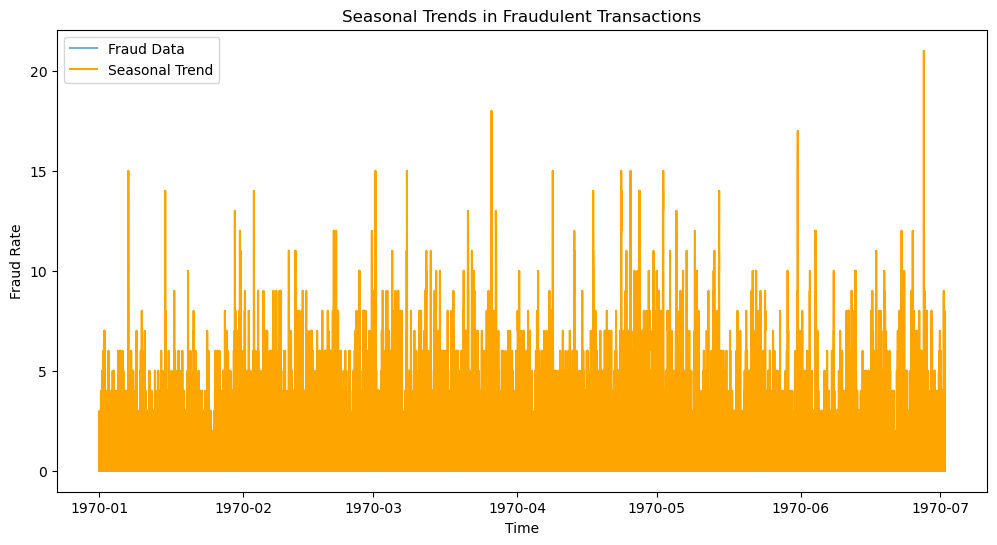

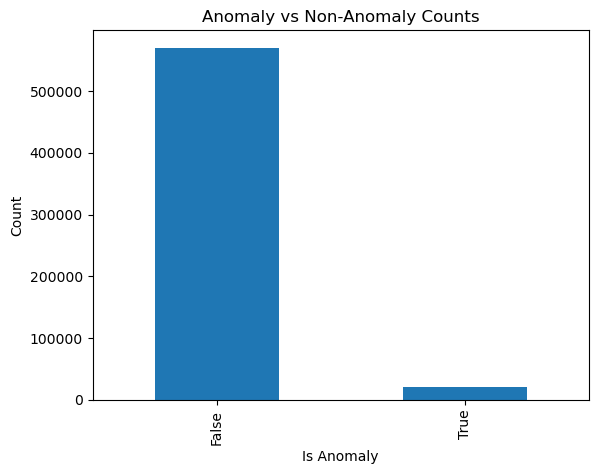

In [115]:
# Visualizing seasonal trends
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_data['time'], train_data['isFraud'], alpha=0.6, label='Fraud Data')
plt.plot(train_data['time'], train_data['30_day_fraud_sum'], color='orange', label='Seasonal Trend')
plt.title('Seasonal Trends in Fraudulent Transactions')
plt.xlabel('Time')
plt.ylabel('Fraud Rate')
plt.legend()
plt.show()

# Bar chart of anomalies
anomaly_counts = train_data.groupby('is_anomaly')['TransactionDT'].count()
anomaly_counts.plot(kind='bar', title='Anomaly vs Non-Anomaly Counts', xlabel='Is Anomaly', ylabel='Count')
plt.show()


In [119]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05)
daily_fraud['anomaly'] = model.fit_predict(daily_fraud.values.reshape(-1, 1))

# Visualize anomalies
daily_fraud[daily_fraud['anomaly'] == -1].plot(style='ro', title="Anomalous Fraudulent Transactions")


ValueError: setting an array element with a sequence.

In [121]:
##SQL CODE TO RUN
WITH daily_fraud AS (
    SELECT 
        DATE(TransactionDate) AS fraud_date,
        COUNT(*) AS fraud_count
    FROM train_data
    WHERE isFraud = 1
    GROUP BY fraud_date
),
moving_avg AS (
    SELECT 
        fraud_date,
        fraud_count,
        AVG(fraud_count) OVER (ORDER BY fraud_date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg
    FROM daily_fraud
)
SELECT * FROM moving_avg;


SyntaxError: invalid syntax (350178422.py, line 2)